# import packages

In [1]:
import warnings 
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from utilities import *
from sklearn.metrics import mean_squared_error
import os
from datetime import datetime


In [2]:
pd.set_option("display.max_rows", 1000)
pd.set_option('display.max_rows',300)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
load_optimzed_model = False

# DATA PREPARATION
## Load the training data and test data

In [3]:

column_name = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
               's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
               's15', 's16', 's17', 's18', 's19', 's20', 's21']

Data_id = "FD002"

train_FD = pd.read_table("./CMAPSSData/train_{}.txt".format(Data_id), header=None, delim_whitespace=True)
train_FD.columns = column_name


test_FD = pd.read_table("./CMAPSSData/test_{}.txt".format(Data_id), header=None, delim_whitespace=True)
test_FD.columns = column_name

RUL_FD = pd.read_table("./CMAPSSData/RUL_{}.txt".format(Data_id), header=None, delim_whitespace=True)

In [4]:
train_FD.describe()

,engine_id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,...,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000
mean,131.08298,109.15475,23.99841,0.57206,94.04602,472.91021,579.67240,1419.97101,1205.44202,8.03199,...,266.06903,2334.55725,8066.59768,9.32965,0.02333,348.30951,2228.80636,97.75684,20.78930,12.47342
std,74.46386,69.18057,14.74738,0.31002,14.23773,26.38971,37.28940,105.94634,119.12343,3.61384,...,137.65951,128.06827,84.83795,0.74934,0.00471,27.75452,145.32798,5.36407,9.86933,5.92162
min,1.00000,1.00000,0.00000,0.00000,60.00000,445.00000,535.53000,1243.73000,1023.77000,3.91000,...,129.12000,2027.61000,7848.36000,8.33570,0.02000,303.00000,1915.00000,84.93000,10.18000,6.01050
25%,68.00000,52.00000,10.00460,0.25070,100.00000,445.00000,549.57000,1352.76000,1123.65500,3.91000,...,131.52000,2387.90000,8062.14000,8.67780,0.02000,331.00000,2212.00000,100.00000,10.91000,6.54630
50%,131.00000,104.00000,25.00130,0.70000,100.00000,462.54000,555.98000,1369.18000,1138.89000,7.05000,...,183.20000,2388.08000,8082.54000,9.31090,0.02000,335.00000,2223.00000,100.00000,14.88000,8.92920
75%,195.00000,157.00000,41.99800,0.84000,100.00000,491.19000,607.34000,1499.37000,1306.85000,10.52000,...,371.26000,2388.17000,8127.19500,9.38690,0.03000,369.00000,2324.00000,100.00000,28.47000,17.08320
max,260.00000,378.00000,42.00800,0.84200,100.00000,518.67000,644.52000,1612.88000,1439.23000,14.62000,...,523.37000,2390.48000,8268.50000,11.06690,0.03000,399.00000,2388.00000,100.00000,39.34000,23.59010


# Compute the remaining useful life

### RUL for Training dataset

Here, we use the piecewise linear degradation model as the target function in the estimation process. 
The degradation of the system typically starts after a certain degree of usage, and hence, we consider this model to be more suited compared to the linear degradation model. [1](https://arxiv.org/abs/1810.05644)
![title](images/piecewise.png)

In [5]:
id='engine_id'
MAXLIFE = 120 # or 125 , 130
# piecewise linear RUL 
rul = [] 
for _id in set(train_FD[id]):
    trainFD_of_one_id =  train_FD[train_FD[id] == _id]
    cycle_list = trainFD_of_one_id['cycle'].tolist()
    max_cycle = max(cycle_list)

    knee_point = max_cycle - MAXLIFE
    kink_RUL = []
    for i in range(0, len(cycle_list)):
        # 
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = max_cycle-i-1
            kink_RUL.append(tmp)
    rul.extend(kink_RUL)

train_FD["RUL"] = rul

### RUL for test dataset

In [6]:
id='engine_id'
rul = []
for _id_test in set(test_FD[id]):
    true_rul = int(RUL_FD.iloc[_id_test - 1])
    testFD_of_one_id =  test_FD[test_FD[id] == _id_test]
    cycle_list = testFD_of_one_id['cycle'].tolist()
    max_cycle = max(cycle_list) + true_rul
    knee_point = max_cycle - MAXLIFE
    kink_RUL = []
    for i in range(0, len(cycle_list)):
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = max_cycle-i-1
            kink_RUL.append(tmp)    

    rul.extend(kink_RUL)

test_FD["RUL"] = rul

# Feature extention

    Remove features that have only unique value
    
    Use correlation test methods (Significance test) to exclude features that are not related to the target variable

In [7]:
col_to_drop = identify_and_remove_unique_columns(train_FD)

In [8]:
train_FD = train_FD.drop(col_to_drop,axis = 1)

In [9]:
test_FD = test_FD.drop(col_to_drop,axis = 1)

## standard normalization 

In [10]:
mean = train_FD.iloc[:, 2:-1].mean()
std = train_FD.iloc[:, 2:-1].std()
std.replace(0, 1, inplace=True)


# training dataset
train_FD.iloc[:, 2:-1] = (train_FD.iloc[:, 2:-1] - mean) / std

# Testing dataset
test_FD.iloc[:, 2:-1] = (test_FD.iloc[:, 2:-1] - mean) / std

### plot a figure

training (53759, 16) (53759,)
testing (33991, 16) (33991,)


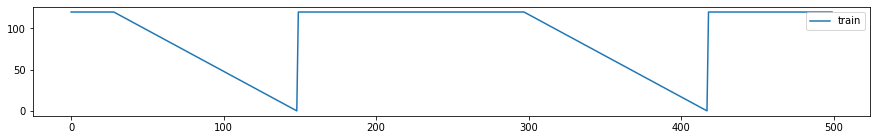

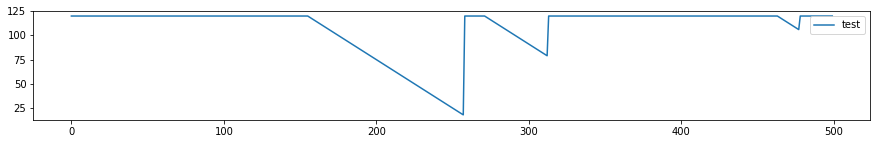

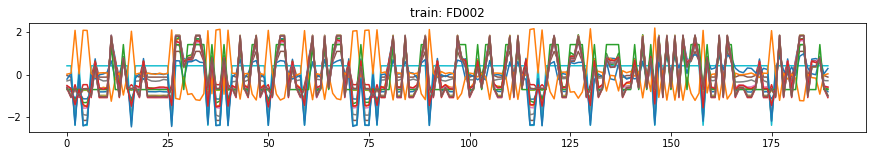

In [11]:
training_data = train_FD.values
testing_data = test_FD.values

x_train = training_data[:, 2:-1]
y_train = training_data[:, -1]
print("training", x_train.shape, y_train.shape)

x_test = testing_data[:, 2:-1]
y_test = testing_data[:, -1]
print("testing", x_test.shape, y_test.shape)

plt.figure(figsize=(15,2))
plt.plot(y_train[:500], label="train")
plt.legend()
plt.figure(figsize=(15,2))

plt.plot(y_test[:500], label="test")
plt.legend()
plt.figure(figsize=(15,2))
plt.plot(x_train[:190])
plt.title("train: " + Data_id )

plt.show()

# Data_Batch generation
    
Data generation with sliding window method
![title](images/sliding.png)
sequence_length defines the window movement steps

Window size defines the time steps included in the window

In the example above, the window size is 4, which is moved by one step

In [12]:
sequence_length=5
window_size = 16
# Prepare the training set according to the  window size and sequence_length
x_batch, y_batch =batch_generator(train_FD,sequence_length=sequence_length,window_size = window_size)

x_batch = np.expand_dims(x_batch, axis=4)
y_batch = np.expand_dims(y_batch, axis=1)

In [13]:
number_of_sensor = x_batch.shape[-2]

# Model

In [14]:
from ECLSTM import ECLSTM1D
from ECLSTM import check_the_config_valid
from ECLSTM import build_the_model


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

    The network below has a naive four-layer architecture.
    The first layer is a ECLSTM layer with 10 filters, and the kernel size is 3.
    The second layer is a ECLSTM layer with 20 filters, and the kernel size is 3.
    The third is forward fully connected layers, with 150 hidden nodes. 
    The last layer is a 1-dimensional output layer which predicts the RUL. 
<font color=red>**This  model is not optimized， But it has been able to achieve state of the art results on FD002 and FD004 dataset. 
And the performance on FD001 and FD002 dataset is also better than the optimized traditional LSTM model.**</font> [[2]](https://ieeexplore.ieee.org/document/7998311) 

It shows that this new LSTM variant has stronger capabilities than LSTM in dealing with multiple time series problems (with large window size).

| Datasets  | FD001  | FD002  | FD003 | FD004  |
|-----------|--------|--------|-------|--------|
|   MLP   |  37.56 | 80.03  | 37.39 | 77.37  | 
|   SVR   | 20.96  | 42.00  | 21.05 | 45.35  |
|   RVR   | 23.80  | 31.30  | 22.37 | 34.34  | 
|   CNN   | 18.45  | 30.29  | 19.82  | 29.16 | 
| Deep LSTM | **16.14** | **24.49**  | **16.18**  | **28.17**  | 

The RMSE values in this table are used as the baseline for comparison

In [15]:
# specify the achtecture parameters
para = {
    # preprocessing part
    "preprocessing_layers" : 0,
    "pre_kernel_width" : 3,
    "pre_number_filters" : 10,
    "pre_strides" : 2,
    "pre_activation" : "relu",


    # ECLSTM feature extraction part
    "eclstm_1_recurrent_activation" : ['linear',"hard_sigmoid"],
    "eclstm_1_conv_activation" : ['hard_sigmoid',"hard_sigmoid"],
    "eclstm_1_kernel_width" : [3,3],
    "eclstm_1_number_filters" : [10,10],
    "eclstm_1_strides" : 1,
    "eclstm_1_fusion":["early","early"],
    
    "eclstm_2_recurrent_activation" : ['linear',"hard_sigmoid"],
    "eclstm_2_conv_activation" : ['hard_sigmoid',"hard_sigmoid"],
    "eclstm_2_kernel_width" : [3,3],
    "eclstm_2_number_filters" : [20,20],
    "eclstm_2_strides" : 1,
    "eclstm_2_fusion":["early","early"],

    "eclstm_3_recurrent_activation" : [None],
    "eclstm_3_conv_activation" : [None],
    "eclstm_3_kernel_width" : [None],
    "eclstm_3_number_filters" : [None],
    "eclstm_3_strides" : None,
    "eclstm_3_fusion":[None],

    "eclstm_4_recurrent_activation" : [None],
    "eclstm_4_conv_activation" : [None],
    "eclstm_4_kernel_width" : [None],
    "eclstm_4_number_filters" : [None],
    "eclstm_4_strides" : None,
    "eclstm_4_fusion":[None],

    # Prediction
    "prediction_1_filters" : 150,
    "prediction_1_activation" : "relu",
    
    "prediction_2_filters" : 0,
    "prediction_2_activation" : None,
    
    "prediction_3_filters" : 0,
    "prediction_3_activation" : None,
    
    "prediction_4_filters" : 0,
    "prediction_4_activation" : None,
}

In [16]:
valid = check_the_config_valid(para,window_size,number_of_sensor)
if valid:
    model = build_the_model(para, sequence_length, window_size, number_of_sensor)
else: 
    print("invalid configuration")
input_data = tf.keras.layers.Input(shape=(sequence_length, window_size, number_of_sensor,1))
out = model(input_data)
print(model.summary())

valid Configuration!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper (ModuleWrapp  (None, 5, 12, 1, 10)     5900      
 er)                                                             
                                                                 
 batch_normalization (BatchN  (None, 5, 12, 1, 10)     40        
 ormalization)                                                   
                                                                 
 module_wrapper_1 (ModuleWra  (None, 8, 1, 20)         18160     
 pper)                                                           
                                                                 
 batch_normalization_1 (Batc  (None, 8, 1, 20)         80        
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None,

# Train the model

In [17]:
dateTimeObj = datetime.now()

log_dir = "logs/{}_{}_{}_{}_{}_{}_{}/".format(Data_id,
                                              dateTimeObj.year,
                                              dateTimeObj.month,
                                              dateTimeObj.day,
                                              dateTimeObj.hour,
                                              dateTimeObj.minute,
                                              dateTimeObj.second)


os.makedirs(log_dir)

checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
                             monitor='val_loss', save_weights_only=True, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

In [18]:
# if you have enough time budget, you can set a large epochs and large patience

if load_optimzed_model == False: 
    model.fit(x_batch,y_batch, 
            batch_size=15, 
            epochs=30, 
            callbacks=[#logging, 
                        checkpoint, 
                        reduce_lr, 
                        early_stopping],
            validation_split=0.075)
    model.save_weights(log_dir + 'trained_weights_final.h5')

Epoch 1/30
3011/3011 [==============================] - 81s 24ms/step - loss: 607.5673 - val_loss: 863.9408 - lr: 0.0010
Epoch 2/30
3011/3011 [==============================] - 123s 41ms/step - loss: 452.8159 - val_loss: 597.0868 - lr: 0.0010
Epoch 3/30
3011/3011 [==============================] - 169s 56ms/step - loss: 437.8474 - val_loss: 902.0971 - lr: 0.0010
Epoch 4/30
3011/3011 [==============================] - 128s 43ms/step - loss: 423.5306 - val_loss: 426.7210 - lr: 0.0010
Epoch 5/30
3011/3011 [==============================] - 68s 23ms/step - loss: 406.2235 - val_loss: 377.3619 - lr: 0.0010
Epoch 6/30
3011/3011 [==============================] - 72s 24ms/step - loss: 392.7730 - val_loss: 509.0161 - lr: 0.0010
Epoch 7/30
3011/3011 [==============================] - 83s 28ms/step - loss: 385.7968 - val_loss: 484.5057 - lr: 0.0010
Epoch 8/30
3011/3011 [==============================] - 116s 38ms/step - loss: 371.5097 - val_loss: 355.7283 - lr: 0.0010
Epoch 9/30
3011/3011 [======

# Evaluation

## load the best model

In [19]:
def evaluate(): 

    x_batch_test, y_batch_test =  test_batch_generator(test_FD, sequence_length=sequence_length,window_size = window_size)
    x_batch_test = np.expand_dims(x_batch_test, axis=4)

    def performance():

        # performance on training dataset
        y_batch_pred = model.predict(x_batch)

        y_batch_pred = y_batch_pred.reshape(y_batch_pred.shape[0], y_batch_pred.shape[1])
        y_batch_reshape = y_batch.reshape(y_batch.shape[0], y_batch.shape[1])
        rmse_on_train = np.sqrt(mean_squared_error(y_batch_pred, y_batch_reshape))

        print("The RMSE on Training dataset {} is {}.".format(Data_id,rmse_on_train))

        # performance on test dataset
        y_batch_pred_test = model.predict(x_batch_test)
        rmse_on_test = np.sqrt(mean_squared_error(y_batch_pred_test, y_batch_test))
        print("The RMSE on test dataset {} is {}.".format(Data_id,rmse_on_test))

    if load_optimzed_model == False:
        modellist = os.listdir(log_dir)
        modellist = [file for file in modellist if "val_loss" in file]

        model.load_weights(log_dir+modellist[-1])

        return performance()
        
    if load_optimzed_model == True: 
        print("loading optimzed model ...")
        
        model_id=4
        model_weights = 'trained_models/{}/best_model_{}_{}.h5'.format(Data_id,Data_id,model_id)
        if not os.path.exists(model_weights):
            print("no such a weight file")
        else:
            model.load_weights(model_weights)

        return performance()
            
    

In [20]:
evaluate()

1526/1526 [==============================] - 12s 7ms/step
The RMSE on Training dataset FD002 is 17.03278350830078.
9/9 [==============================] - 0s 5ms/step
The RMSE on test dataset FD002 is 15.185379028320312.


In [21]:
# modellist = os.listdir(log_dir)
# modellist = [file for file in modellist if "val_loss" in file]

In [22]:
# modellist

In [23]:
# model.load_weights(log_dir+modellist[-1])

##  Performance on training dataset

In [24]:
# y_batch_pred = model.predict(x_batch)

In [25]:

# y_batch_pred = y_batch_pred.reshape(y_batch_pred.shape[0], y_batch_pred.shape[1])
# y_batch_reshape = y_batch.reshape(y_batch.shape[0], y_batch.shape[1])
# rmse_on_train = np.sqrt(mean_squared_error(y_batch_pred, y_batch_reshape))

# print("The RMSE on Training dataset {} is {}.".format(Data_id,rmse_on_train))

##  Performance on test dataset

In [26]:
# x_batch_test, y_batch_test =  test_batch_generator(test_FD, sequence_length=sequence_length,window_size = window_size)
# x_batch_test = np.expand_dims(x_batch_test, axis=4)

In [27]:
# We provide 4 trained models. You can load the model with the following command
# Question: where do they create these optimized models?
# -------------------------------------
# if load_optimzed_model == True: 
#     model_id=4
#     model_weights = 'trained_models/{}/best_model_{}_{}.h5'.format(Data_id,Data_id,model_id)
#     if not os.path.exists(model_weights):
#         print("no such a weight file")
#     else:
#         model.load_weights(model_weights)

In [28]:
# y_batch_pred_test = model.predict(x_batch_test)

In [29]:
# rmse_on_test = np.sqrt(mean_squared_error(y_batch_pred_test, y_batch_test))
# print("The RMSE on test dataset {} is {}.".format(Data_id,rmse_on_test))

# Results

The figure shows the average RMSE

| Datasets               | FD001  | FD002  | FD003 | FD004  |
|------------------------------|--------|--------|-------|--------|
|   LSTM (2017)           | 16.14  | 24.49  | 16.18 | 28.17  | 
|   DCNN (2018)           | 12.61  | 22.36  | 12.64 | 23.31  |
|   DAG (2019)            | 11.96  | 20.34  | 12.46 | 22.43  | 
|   Model in this notebook   | 14.92  | **18.11**  | 13.85  | **20.11** | 
|   Optimized Model        | **11.03** | **15.95**  | **11.23**  | **16.21**  | 

# potential

* Time series usually need pre-processing, such as **reducing noise** or **doing difference**. Proper preprocessing will help the model have better results. **1D convolution and difference** can be used as the preprocessing part.

    

* The model above is not optimized for each data set, If the model is **optimized separately** for each data set, the results will be better.

    
    
* How to effectively set these hyperparameters? automated machine learning

